In [1]:
# Import libraries
import pandas as pd
import numpy as np

c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
# Import RandomForestClassifier from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
# Import other stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

In [10]:
# Import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
file_path = 'data/NSDUH_2021_Tab.txt'

data = pd.read_csv(file_path, sep='\t')

In [2]:
dataframe_path = 'data/dataframe.csv'

df = pd.read_csv(dataframe_path)

In [3]:
df.head()

,CIGEVER,MJEVER,ALCEVER,COCEVER,CRKEVER,HEREVER,LSD,METHAMEVR,IRIMPREMEM,ADDPREV,IRSUIPLANYR,ASDSREL2,IRAMDEYR,IRDSTCHR12
0,1,1,1,0,0,0,0,0,2,2,0.0,NaN,0.0,99
1,1,0,1,0,0,0,0,0,99,2,0.0,NaN,0.0,99
2,0,0,1,0,0,0,0,0,1,2,0.0,NaN,0.0,4
3,1,1,1,0,0,0,0,0,2,1,0.0,NaN,0.0,99
4,0,0,0,0,0,0,0,0,99,2,0.0,NaN,0.0,99


In [ ]:
# 'IRIMPREMEM', - DIFFICULTY REMEMBERING ONE MO IN PST 12 MOS - IMP REV (495) --> BINARY!
# 'ADDPREV', - SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD (506) --> BINARY!
# 'IRSUIPLANYR', - ADULT MADE PLANS TO KILL SELF IN PST YR - IMP REV (499)
# 'ASDSREL2', - ADULT: DEP FEELINGS ROLE IMPAIRMENT - CLOSE RELATIONSHIPS (520)
# 'IRAMDEYR', - ADULT: PAST YEAR MAJOR DEPRESSIVE EPISODE (MDE) - IMP REV
# 'IRDSTCHR12' - HOW OFTEN FELT COULDN'T BE CHEERED UP WRST MONTH - IMP REV

In [ ]:
### Thought: Taking all of the target variables above and making an aggregate target variable. This will be the target variable for the model.

### You could take an average of the 6 target variables and scale them to a 0-1 scale. This would be the target variable for the model.

In [ ]:
# IRIMPREMEM - DIFFICULTY REMEMBERING ONE MO IN PST 12 MOS - IMP REV (495)
# 1 = No difficulty ................................................................................................................. 17389 29.96
# 2 = Mild difficulty............................................................................................................... 12505 21.55
# 3 = Moderate difficulty ....................................................................................................... 5745 9.90
# 4 = Severe difficulty............................................................................................................ 1839 3.17
# 99 = LEGITIMATE SKIP................................................................................................... 20556 35.42

In [4]:
df.IRIMPREMEM.value_counts()

99    20397
1     17342
2     12461
3      5708
4      1828
Name: IRIMPREMEM, dtype: int64

In [11]:
# Drop all 99s from the field above and run model with field as target (Difficulty Remembering)

# Drop all irrelevant targets
memory_df = df.drop(['ADDPREV', 'IRSUIPLANYR', 'ASDSREL2',
       'IRAMDEYR', 'IRDSTCHR12'], axis=1)

# Drop all 99s from the target field
memory_df = memory_df[memory_df['IRIMPREMEM'] != 99]

# Inspect
memory_df.IRIMPREMEM.value_counts()


1    17342
2    12461
3     5708
4     1828
Name: IRIMPREMEM, dtype: int64

In [12]:
# Instantiate the classifier
rfc = RandomForestClassifier(n_estimators=150, random_state=42)

# Define X and y
X = memory_df.drop(columns=['IRIMPREMEM'])
y = memory_df['IRIMPREMEM']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the model
rfc.fit(X_train, y_train)

# Make predictions
y_pred_prob = rfc.predict_proba(X_test)

In [13]:
# Import ROCAUC
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score of y_test and y_pred_prob
roc_auc_score(y_test, y_pred_prob, multi_class='ovr') # 'ovr' stands for 'one-vs-rest' and it is sensitive to class imbalance

0.5709892846695729

In [14]:
# Insect balanced classifier
y_pred = rfc.predict(X_test)

# Return a ckassification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.92      0.63      4305
           2       0.37      0.11      0.17      3124
           3       0.28      0.01      0.02      1446
           4       0.00      0.00      0.00       460

    accuracy                           0.46      9335
   macro avg       0.28      0.26      0.21      9335
weighted avg       0.39      0.46      0.35      9335



### Make this feature importance code into function later

In [15]:
# Create feature importance dataframe to analyze the importance of each feature
fi_values = rfc.feature_importances_
features = X_train.columns

# Create dataframe
feature_importance_df = pd.DataFrame({"feature": features, "feature_importance": fi_values})

# Sort in descending order
feature_importance_df = feature_importance_df.sort_values(by="feature_importance", ascending = False)

# View dataframe
feature_importance_df

,feature,feature_importance
1,MJEVER,0.369779
7,METHAMEVR,0.130593
6,LSD,0.108513
3,COCEVER,0.104935
5,HEREVER,0.090615
0,CIGEVER,0.083960
2,ALCEVER,0.059896
4,CRKEVER,0.051709


### Now using RandomOverSampler()

In [16]:
# Resample from training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Print the length of resampled data
print(len(X_resampled))
print(len(y_resampled))

52148
52148


In [17]:
# Retrain data with resampled data
rfc.fit(X_resampled, y_resampled)

# Make predictions
y_pred_prob = rfc.predict_proba(X_test)
y_pred = rfc.predict(X_test)

# Calculate the ROC AUC score of y_test and y_pred_prob
roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

0.5585268619191814

In [18]:
# Return a ckassification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.53      0.53      4305
           2       0.35      0.06      0.10      3124
           3       0.17      0.39      0.24      1446
           4       0.09      0.26      0.13       460

    accuracy                           0.33      9335
   macro avg       0.29      0.31      0.25      9335
weighted avg       0.40      0.33      0.32      9335



In [19]:
df.ADDPREV.value_counts() # SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD

2     29452
1     15988
99    10609
98     1519
97      105
94       57
85        6
Name: ADDPREV, dtype: int64

In [ ]:
# 1 = Yes................................................................................................................................ 16069 27.69
# 2 = No................................................................................................................................. 29524 50.87
# 85 = BAD DATA Logically assigned ................................................................................. 7 0.01
# 94 = DON'T KNOW........................................................................................................... 59 0.10
# 97 = REFUSED .................................................................................................................. 108 0.19
# 98 = BLANK (NO ANSWER) ........................................................................................... 1524 2.63
# 99 = LEGITIMATE SKIP................................................................................................... 10743 18.51

In [20]:
# Clean data
addprev_df = df.drop(['IRIMPREMEM', 'IRSUIPLANYR', 'ASDSREL2',
       'IRAMDEYR', 'IRDSTCHR12'], axis=1)

# Keep only 1s and 2s
addprev_df = addprev_df[(addprev_df['ADDPREV'] == 1) | (addprev_df['ADDPREV'] == 2)]

# Change all 2s to 0s
addprev_df['ADDPREV'] = addprev_df['ADDPREV'].replace(2, 0)

# Inspect
addprev_df.head()

,CIGEVER,MJEVER,ALCEVER,COCEVER,CRKEVER,HEREVER,LSD,METHAMEVR,ADDPREV
0,1,1,1,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0


In [21]:
addprev_df.ADDPREV.value_counts()

0    29452
1    15988
Name: ADDPREV, dtype: int64

### Note this one is binary classification

In [66]:
# Deploy RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

# Define X and y
X = addprev_df.drop('ADDPREV', axis=1)
y = addprev_df['ADDPREV']

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit model
rfc.fit(X_train, y_train)

# Predict
y_pred_prob = rfc.predict_proba(X_test)[:,1]

In [67]:
# Calculate ROC AUC
ROCAUC = roc_auc_score(y_test, y_pred_prob)

# Print ROC AUC
ROCAUC

0.6210442875663953

In [68]:
# Make predications
y_pred = rfc.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.98      0.79      5951
           1       0.56      0.06      0.11      3137

    accuracy                           0.66      9088
   macro avg       0.61      0.52      0.45      9088
weighted avg       0.63      0.66      0.55      9088



### Deploy resampling methods

In [69]:
# Resample from training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Print the length of resampled data
print(len(X_resampled))
print(len(y_resampled))

47002
47002


In [70]:
# Retrain model with resampled data and test on test set
rfc.fit(X_resampled, y_resampled)

# Predict on test set
y_pred_prob = rfc.predict_proba(X_test)[:,1]

In [71]:
# Calculate ROC AUC
ROCAUC = roc_auc_score(y_test, y_pred_prob)

# Print ROC AUC
ROCAUC

0.6210359847156839

In [72]:
# Get classification report

# Make predications
y_pred = rfc.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64      5951
           1       0.44      0.64      0.52      3137

    accuracy                           0.59      9088
   macro avg       0.59      0.60      0.58      9088
weighted avg       0.64      0.59      0.60      9088



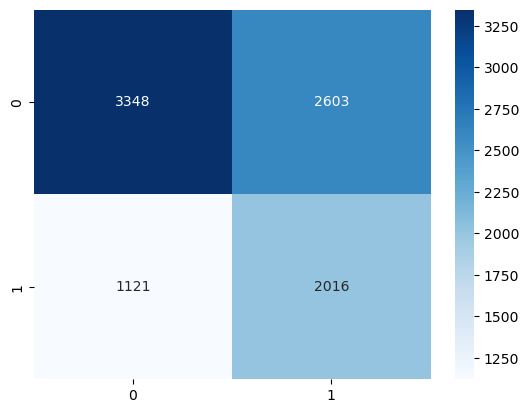

In [73]:
# Produce confusion matrix using seaborn heatmap

import seaborn as sns
import matplotlib.pyplot as plt

ax1 = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.show(ax1)

### Best model yet!

In [74]:
# Create feature importance dataframe to analyze the importance of each feature
fi_values = rfc.feature_importances_
features = X_train.columns

# Create dataframe
feature_importance_df = pd.DataFrame({"feature": features, "feature_importance": fi_values})

# Sort in descending order
feature_importance_df = feature_importance_df.sort_values(by="feature_importance", ascending = False)

# View dataframe
feature_importance_df

,feature,feature_importance
1,MJEVER,0.302007
6,LSD,0.249118
2,ALCEVER,0.178471
3,COCEVER,0.136040
7,METHAMEVR,0.067472
0,CIGEVER,0.052300
5,HEREVER,0.011469
4,CRKEVER,0.003122


<Axes: xlabel='feature'>

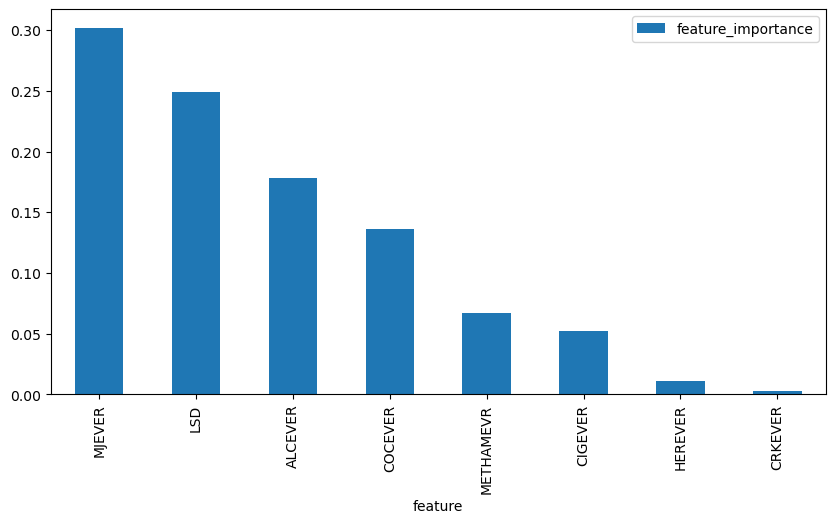

In [78]:
# Plot the feature importance of the model using a bar graph

feature_importance_df.plot.bar(x='feature', y='feature_importance', rot=90, figsize=(10, 5), fontsize=10)

In [33]:
# q: How do I get the correlation coefficient between each feature and the target in a dataframe?
# a: df.corr()['target'].sort_values(ascending=False)

addprev_df.corr()['ADDPREV'].sort_values(ascending=False)

ADDPREV      1.000000
MJEVER       0.199090
LSD          0.141680
COCEVER      0.130175
ALCEVER      0.114207
CIGEVER      0.100959
METHAMEVR    0.098456
HEREVER      0.072134
CRKEVER      0.065931
Name: ADDPREV, dtype: float64

In [11]:
df.columns

Index(['CIGEVER', 'MJEVER', 'ALCEVER', 'COCEVER', 'CRKEVER', 'HEREVER', 'LSD',
       'METHAMEVR', 'IRIMPREMEM', 'ADDPREV', 'IRSUIPLANYR', 'ASDSREL2',
       'IRAMDEYR', 'IRDSTCHR12'],
      dtype='object')

In [6]:
# ADULT MADE PLANS TO KILL SELF IN PST YR - IMP REV (499)
df.IRSUIPLANYR.value_counts()

0.0    46168
1.0      959
Name: IRSUIPLANYR, dtype: int64

In [79]:
# Create a suicide_df

suicide_df = df.drop(['IRIMPREMEM', 'ADDPREV', 'ASDSREL2',
       'IRAMDEYR', 'IRDSTCHR12'], axis=1)

# Inspect
suicide_df.head()

,CIGEVER,MJEVER,ALCEVER,COCEVER,CRKEVER,HEREVER,LSD,METHAMEVR,IRSUIPLANYR
0,1,1,1,0,0,0,0,0,0.0
1,1,0,1,0,0,0,0,0,0.0
2,0,0,1,0,0,0,0,0,0.0
3,1,1,1,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0.0


In [80]:
suicide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57736 entries, 0 to 57735
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CIGEVER      57736 non-null  int64  
 1   MJEVER       57736 non-null  int64  
 2   ALCEVER      57736 non-null  int64  
 3   COCEVER      57736 non-null  int64  
 4   CRKEVER      57736 non-null  int64  
 5   HEREVER      57736 non-null  int64  
 6   LSD          57736 non-null  int64  
 7   METHAMEVR    57736 non-null  int64  
 8   IRSUIPLANYR  47127 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 4.0 MB


In [81]:
# Drop null values
suicide_df = suicide_df.dropna()

# Convert to integer
suicide_df['IRSUIPLANYR'] = suicide_df['IRSUIPLANYR'].astype(int)

# Reinspect
suicide_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47127 entries, 0 to 57735
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CIGEVER      47127 non-null  int64
 1   MJEVER       47127 non-null  int64
 2   ALCEVER      47127 non-null  int64
 3   COCEVER      47127 non-null  int64
 4   CRKEVER      47127 non-null  int64
 5   HEREVER      47127 non-null  int64
 6   LSD          47127 non-null  int64
 7   METHAMEVR    47127 non-null  int64
 8   IRSUIPLANYR  47127 non-null  int32
dtypes: int32(1), int64(8)
memory usage: 3.4 MB


In [82]:
# Run RandomForestClassifier on suicide_df

# Instantiate the classifier
rfc = RandomForestClassifier(n_estimators=150, random_state=42)

# Define X and y
X = suicide_df.drop(columns=['IRSUIPLANYR'])
y = suicide_df['IRSUIPLANYR']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the model
rfc.fit(X_train, y_train)

# Make predictions
y_pred_prob = rfc.predict_proba(X_test)[:,1]

In [83]:
# Calculate ROC AUC
ROCAUC = roc_auc_score(y_test, y_pred_prob)

# Print ROC AUC
ROCAUC

0.6184031376336953

In [84]:
# Get y_pred
y_pred = rfc.predict(X_test)

# Return classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11546
           1       0.00      0.00      0.00       236

    accuracy                           0.98     11782
   macro avg       0.49      0.50      0.49     11782
weighted avg       0.96      0.98      0.97     11782



c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### Address class imbalance with resampling

In [85]:
# Resample from training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Print the length of resampled data
print(len(X_resampled))
print(len(y_resampled))

69244
69244


In [86]:
# Retrain model with resampled data and test on test set
rfc.fit(X_resampled, y_resampled)

# Predict on test set
y_pred_prob = rfc.predict_proba(X_test)[:,1]

In [87]:
# Get ROC AUC score
roc_auc_score(y_test, y_pred_prob)

0.6145497229945363

In [88]:
# Return another classification report

# Get y_pred
y_pred = rfc.predict(X_test)

# Return classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     11546
           1       0.03      0.43      0.06       236

    accuracy                           0.72     11782
   macro avg       0.51      0.58      0.45     11782
weighted avg       0.97      0.72      0.82     11782



In [92]:
# Perform Random Under Sampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_under, y_under = rus.fit_resample(X_train, y_train)

# Print lengths
print(len(X_under))
print(len(y_under))

1446
1446


In [93]:
# Retrain model with under sampled data and test on test set
rfc.fit(X_under, y_under)

# Predict on test set
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Get ROC AUC score
roc_auc_score(y_test, y_pred_prob)

0.622555834143162

In [94]:
# Get y_pred
y_pred = rfc.predict(X_test)

# Return classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     11546
           1       0.03      0.44      0.06       236

    accuracy                           0.72     11782
   macro avg       0.51      0.58      0.44     11782
weighted avg       0.97      0.72      0.82     11782



In [ ]:
### Do we oversample the test set?

### Stopping here as breakpoint.

### 1. Having working rfcs for the following:
### 'IRIMPREMEM', 'ADDPREV', 'IRSUIPLANYR'

In [ ]:
# 'ASDSREL2', # ADULT: DEP FEELINGS ROLE IMPAIRMENT - CLOSE RELATIONSHIPS (520)
# 'IRAMDEYR', # ADULT: PAST YEAR MAJOR DEPRESSIVE EPISODE (MDE) - IMP REV
# 'IRDSTCHR12' # HOW OFTEN FELT COULDN'T BE CHEERED UP WRST MONTH - IMP REV

In [44]:
df.columns

Index(['CIGEVER', 'MJEVER', 'ALCEVER', 'COCEVER', 'CRKEVER', 'HEREVER', 'LSD',
       'METHAMEVR', 'IRIMPREMEM', 'ADDPREV', 'IRSUIPLANYR', 'ASDSREL2',
       'IRAMDEYR', 'IRDSTCHR12'],
      dtype='object')

In [53]:
# ASDSREL2 # ADULT: DEP FEELINGS ROLE IMPAIRMENT - CLOSE RELATIONSHIPS (520) --> Chose relationships because we predicted it to be the most relevant target to our study.

# Make relationship_df
relationship_df = df.drop(['IRIMPREMEM', 'ADDPREV', 'IRSUIPLANYR', 'IRAMDEYR', 'IRDSTCHR12'], axis=1)

# Inspect target
relationship_df.ASDSREL2.value_counts()

3.0    1875
4.0    1718
2.0     829
5.0     501
1.0     186
Name: ASDSREL2, dtype: int64

In [54]:
relationship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57736 entries, 0 to 57735
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CIGEVER    57736 non-null  int64  
 1   MJEVER     57736 non-null  int64  
 2   ALCEVER    57736 non-null  int64  
 3   COCEVER    57736 non-null  int64  
 4   CRKEVER    57736 non-null  int64  
 5   HEREVER    57736 non-null  int64  
 6   LSD        57736 non-null  int64  
 7   METHAMEVR  57736 non-null  int64  
 8   ASDSREL2   5109 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 4.0 MB


In [55]:
# Drop NA from ASDSREL2

relationship_df = relationship_df.dropna()

In [56]:
relationship_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 9 to 57724
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CIGEVER    5109 non-null   int64  
 1   MJEVER     5109 non-null   int64  
 2   ALCEVER    5109 non-null   int64  
 3   COCEVER    5109 non-null   int64  
 4   CRKEVER    5109 non-null   int64  
 5   HEREVER    5109 non-null   int64  
 6   LSD        5109 non-null   int64  
 7   METHAMEVR  5109 non-null   int64  
 8   ASDSREL2   5109 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 399.1 KB


In [ ]:
# . = Aged 12-17/Unkn/Legit Skip (Otherwise)..................................................................... 52894 91.14
# 1 = None (ADPSRELS=0).................................................................................................. 186 0.32
# 2 = Mild (ADPSRELS=1,2,3)............................................................................................. 833 1.44
# 3 = Moderate (ADPSRELS=4,5,6) ..................................................................................... 1883 3.24
# 4 = Severe (ADPSRELS=7,8,9).......................................................................................... 1733 2.99
# 5 = Very Severe (ADPSRELS=10)..................................................................................... 505 0.87

In [57]:
# Instantiate the classifier
rfc = RandomForestClassifier(n_estimators=150, random_state=42)

# Define X and y
X = relationship_df.drop(columns=['ASDSREL2'])
y = relationship_df['ASDSREL2']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the model
rfc.fit(X_train, y_train)

# Make predictions
y_pred_prob = rfc.predict_proba(X_test)

In [59]:
# Calculate the ROC AUC score of y_test and y_pred_prob
roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

0.542572058168723

In [60]:
# Calculate y_pred and return a classification report
y_pred = rfc.predict(X_test)

# Print report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        40
         2.0       0.00      0.00      0.00       210
         3.0       0.39      0.79      0.52       480
         4.0       0.35      0.25      0.29       412
         5.0       0.00      0.00      0.00       136

    accuracy                           0.38      1278
   macro avg       0.15      0.21      0.16      1278
weighted avg       0.26      0.38      0.29      1278



c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [62]:
# Use over sampling then retest the model
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Retrain the model
rfc.fit(X_resampled, y_resampled)

# Predict the test data
y_pred_prob = rfc.predict_proba(X_test)

# Return the ROC AUC score
roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

0.540092738652541

In [63]:
# Calculate y_pred and return classification report
y_pred = rfc.predict(X_test)

# Print report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.04      0.38      0.07        40
         2.0       0.22      0.22      0.22       210
         3.0       0.39      0.24      0.30       480
         4.0       0.21      0.06      0.09       412
         5.0       0.11      0.21      0.15       136

    accuracy                           0.18      1278
   macro avg       0.20      0.22      0.16      1278
weighted avg       0.27      0.18      0.19      1278



### Notes: Even retrained with oversampled data, the Random Forest Classifier for Relationship Role Impairment performs very poorly.

In [ ]:
# IRAMDEYR

In [ ]:
# IRDSTCHR12

# Section II: AutoSklearn

### Breakpoint: For the sake of time, use AutoML on the most promising target variable, 'ADDPREV' in addprev_df, to test several models and find the best one.

In [64]:
# Import autosklearn classification model
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

# Define X and y
X = addprev_df.drop('ADDPREV', axis=1)
y = addprev_df['ADDPREV']

# Split data into train and test subsets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Create an AutoSklearnClassifier instance
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,  # Maximum time in seconds
    per_run_time_limit=30,        # Maximum time for each model in seconds
    include_estimators=['random_forest', 'extra_trees', 'gradient_boosting'],
    exclude_preprocessors=['no_preprocessing'],
    ensemble_size=1,              # Number of models in the ensemble
    ensemble_nbest=1              # Number of models selected for the ensemble
)

# Fit model
automl.fit(X_resampled, y_resampled)

# Get the best performing model
best_model = automl.get_best_estimator()

# Predict
y_pred = best_model.predict(X_test)

# Print accuracy score
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred))

ModuleNotFoundError: No module named 'autosklearn'

In [18]:
# Import sweetviz
import sweetviz as sv
np.bool = np.bool_

# Analyze the dataset with IRSUIPLANYR as the target variable and all EVER variables as features

# Subset the dataframe to include the first 7 columns and IRSUIPLANYR
sui_df = df.iloc[:, 0:8]
sui_df['IRSUIPLANYR'] = df['IRSUIPLANYR']

# Drop all null values
sui_df = sui_df.dropna()

# Set IRSUIPLANYR's data type to int
sui_df['IRSUIPLANYR'] = sui_df['IRSUIPLANYR'].astype(int)

# Inspect dataframe
sui_df.head()

,CIGEVER,MJEVER,ALCEVER,COCEVER,CRKEVER,HEREVER,LSD,METHAMEVR,IRSUIPLANYR
0,1,1,1,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


In [20]:
# Inspect sui_df info()
sui_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47127 entries, 0 to 57735
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CIGEVER      47127 non-null  int64
 1   MJEVER       47127 non-null  int64
 2   ALCEVER      47127 non-null  int64
 3   COCEVER      47127 non-null  int64
 4   CRKEVER      47127 non-null  int64
 5   HEREVER      47127 non-null  int64
 6   LSD          47127 non-null  int64
 7   METHAMEVR    47127 non-null  int64
 8   IRSUIPLANYR  47127 non-null  int32
dtypes: int32(1), int64(8)
memory usage: 3.4 MB


In [19]:
# Run report
sui_report = sv.analyze(sui_df, target_feat='IRSUIPLANYR')

# Save report as HTML file
sui_report.show_html('sui_report.html')

c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\e.a.wright\anac

Report sui_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [22]:
# Check value_counts() again before building model
df.IRSUIPLANYR.value_counts()

0.0    46168
1.0      959
Name: IRSUIPLANYR, dtype: int64

### There is a serious class imbalance in the dataset that will need to be addressed using resampling.

In [24]:
# Import scikit-learn LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

# Instantiate the classifier
clf = LogisticRegression()

# Define X and y
X = sui_df.drop(['IRSUIPLANYR'], axis=1)
y = sui_df['IRSUIPLANYR']

# Break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the classifier
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

In [25]:
# Print classification report
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18449
           1       0.00      0.00      0.00       402

    accuracy                           0.98     18851
   macro avg       0.49      0.50      0.49     18851
weighted avg       0.96      0.98      0.97     18851



c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\e.a.wright\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [ ]:
# Rectify the class imbalance with oversampling


In [ ]:
# Return confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax1 = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.show(ax1)

In [8]:
df.ASDSREL2.value_counts()

3.0    1875
4.0    1718
2.0     829
5.0     501
1.0     186
Name: ASDSREL2, dtype: int64

In [9]:
df.IRAMDEYR.value_counts()

0.0    41736
1.0     5391
Name: IRAMDEYR, dtype: int64

In [10]:
df.IRDSTCHR12.value_counts()

99    40436
3      4317
4      3814
5      3631
2      3511
1      2027
Name: IRDSTCHR12, dtype: int64